# Exploratory Data Analysis


# Bank Loan Defaulter Hackathon Project
### Submitted by Himanshu Saini
#### Dataset Link: https://www.kaggle.com/datasets/ankitkalauni/bank-loan-defaulter-prediction-hackathon

## 1. Setup

In [273]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings

# Warnings
#import warnings
#warnings.filterwarnings("ignore", category = DeprecationWarning)
#warnings.filterwarnings("ignore", category = FutureWarning)
#warnings.filterwarnings("ignore", category = UserWarning)

# Global style for plots
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    "xtick.color": "black",
    "ytick.color": "black",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.top": False,
    "ytick.right": False,
    "figure.dpi": 150,
    "legend.frameon": True,
    "legend.facecolor": "white",
    "legend.edgecolor": "black",
    "legend.fontsize": 12
})

# Apply to seaborn
sns.set_theme(context="notebook", style="ticks")

# Reproducibility
rnd_num = 42
rng = np.random.seed(rnd_num)

# Root directory
ROOT = Path(os.getcwd()).parent

# Data directory
DATA_DIR = Path(ROOT/"data")
RAW = Path(DATA_DIR/"raw")
assert (RAW/"train.csv").exists() and (RAW/"test.csv").exists(), "Data files are missing!"

# Results directory
RESULT_DIR = Path(ROOT/"results")
RESULT_DIR.mkdir(exist_ok=True, parents=True)

# Model directory
MODEL_DIR = Path(ROOT/"models")
MODEL_DIR.mkdir(exist_ok=True, parents=True)

## 2. Helper functions.

In [274]:
# Figure saver helper (use after each plot)
def savefig(name, out_dir = None):
    out_dir = Path(out_dir) if out_dir else Path(".")
    out_dir.mkdir(parents=True, exist_ok=True)
    path = out_dir / name
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print("Saved:", path)

## 3. Load the data

In [275]:
# Download the data
df_train = pd.read_csv(RAW/"train.csv")
df_test = pd.read_csv(RAW/"test.csv")

## 4. Exploratory Data Analysis (EDA).

In [276]:
# Libraries for EDA
import json, re, math
from typing import Optional, List, Dict, Any, Tuple, Union
from pandas.api.types import is_numeric_dtype, is_datetime64_any_dtype, is_bool_dtype, is_object_dtype
import csv
from sklearn.feature_selection import mutual_info_classif


### 4.1 Context & Assumptions

In [277]:
# Context & Assumptions.

def guess_datetime_format(s: pd.Series, sample_size: int = 1000, min_accept_rate: float = 0.8) -> Tuple[pd.Series, Dict[str, Any]]:
    """
    Try common datetime formats on a sample and choose a consistent parser.

    Parameters
    ----------
    s : pandas.Series
        Candidate date/time column.
    sample_size : int, default 1000
        Maximum number of non-null samples to test for format selection.
    min_accept_rate : float, default 0.8
        Minimum fraction of sample values that must parse under a format to accept it.

    Returns
    -------
    tuple[pandas.Series, dict]
        - Parsed datetime series (NaT where parsing failed).
        - Metadata dict: {'format': str|None, 'mode': 'fixed-format'|'dateutil-auto', 'parse_rate': float}

    Notes
    -----
    Falls back to dateutil-based parsing (mode='dateutil-auto') if no fixed format meets the acceptance rate.
    """
    s_str = s.astype("string")
    sample = s_str.dropna().sample(min(sample_size, s_str.dropna().shape[0]), random_state=42) if s_str.dropna().shape[0] else s_str.dropna()

    candidate_formats = [
        "%Y-%m-%d",
        "%Y/%m/%d",
        "%d-%m-%Y",
        "%m-%d-%Y",
        "%d/%m/%Y",
        "%m/%d/%Y",
        "%Y-%m-%d %H:%M:%S",
        "%Y/%m/%d %H:%M:%S",
        "%Y-%m-%dT%H:%M:%S",
        "%Y-%m-%dT%H:%M:%S.%f",
    ]

    best_fmt = None
    best_rate = -1.0
    for fmt in candidate_formats:
        if sample.empty:
            rate = 0.0
        else:
            parsed = pd.to_datetime(sample, format=fmt, errors="coerce")
            rate = float(parsed.notna().mean())
        if rate > best_rate:
            best_fmt, best_rate = fmt, rate

    if best_rate >= min_accept_rate:
        parsed_full = pd.to_datetime(s_str, format=best_fmt, errors="coerce")
        meta = {"format": best_fmt, "mode": "fixed-format", "parse_rate": float(parsed_full.notna().mean())}
        return parsed_full, meta

    # Fallback: dateutil (no fixed format), suppress the noisy warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        parsed_full = pd.to_datetime(s_str, errors="coerce", yearfirst=True)
    meta = {"format": None, "mode": "dateutil-auto", "parse_rate": float(parsed_full.notna().mean())}
    return parsed_full, meta

def is_id_like(s: pd.Series, n_rows: int) -> bool:
    """
    Heuristic check for ID-like columns.

    Parameters
    ----------
    s : pandas.Series
        Column to evaluate.
    n_rows : int
        Number of rows in the parent dataframe.

    Returns
    -------
    bool
        True if the column looks like a unique identifier (non-null and unique for almost all rows).
    """
    non_null = s.notna().sum()
    nunique = s.nunique(dropna=True)
    return (non_null == n_rows) and (nunique >= max(100, int(0.9 * n_rows)))

def date_like_cols(df: pd.DataFrame):
    """
    Detect date/time columns by dtype or name patterns.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.

    Returns
    -------
    list[str]
        Columns that are datetime dtype or whose names contain date/time tokens.
    """
    out = []
    for c in df.columns:
        if is_datetime64_any_dtype(df[c]): out.append(c); continue
        cl = c.lower()
        if any(tok in cl for tok in ["date", "time", "timestamp", "issued", "application", "approval"]):
            out.append(c)
    # dedupe preserve order
    seen=set(); res=[]
    for x in out:
        if x not in seen: res.append(x); seen.add(x)
    return res

def binary_or_low_card(s: pd.Series, max_card=10):
    return s.nunique(dropna=True) <= max_card

def minority_label(s: pd.Series):
    """
    Infer the positive class as the minority label in a series.

    Parameters
    ----------
    s : pandas.Series
        Target series.

    Returns
    -------
    any or None
        The label with the smallest count, or None if empty.
    """
    vc = s.value_counts(dropna=False)
    if vc.empty: return None
    # choose smallest count label as "positive" by default
    return vc.index[-1]

def score_target_candidate(col: str, s: pd.Series, in_test: bool) -> float:
    """
    Score a column's likelihood of being the target using simple heuristics.

    Parameters
    ----------
    col : str
        Column name.
    s : pandas.Series
        Column data (train).
    in_test : bool
        Whether this column also exists in the test set.

    Returns
    -------
    float
        Higher score means more likely to be the target.

    Heuristics
    ----------
    + Present only in train (strong hint)
    + Binary or low-cardinality
    + Not ID-like
    + Plausible class imbalance
    (+ Optional name hints used externally as tie-breakers)
    """
    # Higher score is more likely target
    score = 0.0
    
    if not in_test:
        score += 3.0
    nunq = s.nunique(dropna=True)
    
    if nunq == 2:
        score += 2.0
    elif 3 <= nunq <= 10:
        score += 1.0
    
    if not is_id_like(s, len(s)):
        score += 1.0
    
    if nunq in (1, 0):
        return -1e9  # constant or empty
    if nunq == 2:
        vc = s.value_counts(dropna=False)
        minority_rate = vc.min() / vc.sum()
        if 0.01 <= minority_rate <= 0.80: score += 0.5
        else: score -= 0.5
    return score

def infer_context(train: pd.DataFrame, test: pd.DataFrame, user=None):
    """
    Infer core EDA/ETL context from train/test dataframes with optional user overrides.
    Parameters
    ----------
    train : pandas.DataFrame
        Training dataset with the target column and features.
    test : pandas.DataFrame
        Test dataset without the target (typical Kaggle-style split).
    user : dict or None, optional
        Optional overrides and hints. Supported keys:
        - 'target' (str): Explicit target column name.
        - 'positive_label' (any): Value to treat as the positive class.
        - 'id_cols' (list[str]): Columns to treat as identifiers.
        - 'date_cols' (list[str]): Columns to parse as datetimes.
        - 'name_hints' (list[str]): Regex patterns to bias target ranking as a tie-breaker.

    Returns
    -------
    dict
        A context dictionary with:
        - 'target_col' (str | None)
        - 'positive_label' (any | None)
        - 'id_cols' (list[str])
        - 'date_cols' (list[str])

    Notes
    -----
    - When 'user' provides any of the above keys, those values take precedence.
    - If 'target' is not provided, the function ranks candidates using:
    present-only-in-train, low cardinality, non-ID-like, plausible imbalance,
    and optional 'name_hints' as a tie-breaker.
    - If 'positive_label' is not provided, the minority class in train[target] is used by default.
    """
    user = user or {}
    # ID candidates (both frames combined heuristic)
    id_candidates = []
    for c in train.columns:
        if c in test.columns and is_id_like(train[c], len(train)):
            id_candidates.append(c)
    id_cols = user.get("id_cols") or id_candidates

    # Date columns
    date_cols = user.get("date_cols") or date_like_cols(train)

    # Target inference (if not provided)
    target = user.get("target")
    if target is None:
        present_only_in_train = [c for c in train.columns if c not in test.columns]
        candidates = []
        for c in train.columns:
            s = train[c]
            in_test = c in test.columns
            candidates.append((
                c,
                score_target_candidate(c, s, in_test),
                s.nunique(dropna=True)
            ))
        # rank by score desc, then lower cardinality preferred
        candidates.sort(key=lambda x: (-x[1], x[2], x[0]))
        # filter implausible ones
        ranked = [c for c,score,_ in candidates if score > -1e8]
        # prefer those only in train
        ranked = sorted(ranked, key=lambda c: (c not in test.columns, ), reverse=True)
        # skip obvious non-targets (all-ID like)
        for c in ranked:
            s = train[c]
            if is_id_like(s, len(s)): continue
            if s.nunique(dropna=True) <= 10:  # target usually low-card
                target = c
                break

    # Positive label inference
    pos_label = user.get("positive_label")
    if target is not None and pos_label is None and target in train.columns:
        pos_label = minority_label(train[target])

    return {
        "target_col": target,
        "positive_label": pos_label,
        "id_cols": id_cols,
        "date_cols": date_cols,
    }

In [278]:
# 2) Pretty preview: shapes, target balance, ID uniqueness, date ranges
def _print_context_preview(ctx, train, test, max_levels=10):
    """
    Print an EDA context preview and return a date parsing strategy.

    Parameters
    ----------
    ctx : dict
        Context with keys 'target_col', 'positive_label', 'id_cols', 'date_cols'.
    train : pandas.DataFrame
        Training dataframe.
    test : pandas.DataFrame
        Test dataframe.
    max_levels : int, default 10
        Max number of value counts rows to display for the target.

    Returns
    -------
    dict
        'date_parse' mapping of column -> {'format', 'mode', 'parse_rate'} for later ETL reuse.
    """
    print("Inferred Context (Preview)")
    print(f"- Train shape: {train.shape} | Test shape: {test.shape}")
    print(f"- Target column: {ctx.get('target_col')!r}")
    tgt = ctx.get("target_col")
    if tgt and tgt in train.columns:
        vc = train[tgt].value_counts(dropna=False)
        total = int(vc.sum())
        pos = ctx.get("positive_label")
        pos_count = int(vc.get(pos, 0)) if pos is not None else None
        print(f"  Target value counts:")
        print(vc.head(max_levels))
        rate = (100.0 * pos_count / total) if (pos_count and total) else None
        print(f"  Positive label: {pos!r} | Positive rate: {rate:.3f}%"
              if rate is not None else f"  Positive label: {pos!r} (not found in counts)")
    else:
        print("  WARNING: Target column not found in train.")

    id_cols = ctx.get("id_cols") or []
    if id_cols:
        print(f"- ID columns: {id_cols}")
        for c in id_cols:
            if c in train.columns:
                nunq = train[c].nunique(dropna=True)
                non_null = train[c].notna().sum()
                print(f"  {c}: unique={nunq} / non_null={non_null} "
                      f"({'OK unique' if nunq==non_null and non_null>0 else 'not unique'})")
            else:
                print(f"  {c}: not in train")
    else:
        print("- ID columns: []")

    DATE_PARSE_CFG = {}  # collect formats for ETL
    DATE_COLS = ctx.get("date_cols") or []
    print("- Date/Time columns:")
    for c in DATE_COLS:
        if c not in train.columns:
            print(f"  {c}: not in train"); continue
        s_dt, meta = guess_datetime_format(train[c])
        print(f"  {c}: min={s_dt.min()} | max={s_dt.max()} | nulls={int(s_dt.isna().sum())} "
            f"| parse_rate={meta['parse_rate']:.2%} | mode={meta['mode']}" +
            (f" | format={meta['format']}" if meta['format'] else ""))

        # Keep chosen parse strategy for later notebooks
        DATE_PARSE_CFG[c] = meta
    """
    date_cols = ctx.get("date_cols") or []
    if date_cols:
        print(f"- Date/Time columns: {date_cols}")
        for c in date_cols:
            if c in train.columns:
                s = pd.to_datetime(train[c], errors="coerce")
                print(f"  {c}: min={s.min()} | max={s.max()} | nulls={(s.isna().sum())}")
            else:
                print(f"  {c}: not in train")
    else:
        print("- Date/Time columns: []")
    print("=" * 38)
    """

In [279]:
df_train.columns[df_train.nunique() == df_train.shape[0]].tolist()

['ID']

### NOTE: EDA_USER
~~~~python
# EDA_USER: optional user overrides for EDA/ETL context and behavior.
# Only 'target', 'positive_label', 'id_cols', 'date_cols', and 'name_hints'
# are consumed by infer_context() today. The rest are optional and used by
# helper functions and later steps (ETL, plotting, saving artifacts).
EDA_USER = {
    # REQUIRED/RECOMMENDED
    # target: Exact column name of the label in train.
    # positive_label: Value representing the “positive” class (e.g., 1, "Default", "Charged Off").
    # id_cols: Columns to treat as unique identifiers (excluded from features).
    # date_cols: Columns to be parsed as datetimes (formats are learned and stored in ctx['date_parse']).
    # name_hints: Regex strings to bias target guessing as a tie-breaker (ignored if 'target' is set).
    # Example:
    # "target": "Loan Status",
    # "positive_label": "Default",
    # "id_cols": ["Loan_ID"],
    # "date_cols": ["Application_Date", "Disbursed_Date"],
    # "name_hints": [r"default", r"status", r"loan_status", r"target", r"label"],

    # OPTIONAL — schema and feature selection
    # drop_cols: Columns to explicitly drop (leakage, post-outcome, duplicates).
    # keep_cols: If provided, restrict features to this allowlist (after removing id/target/drop).
    # dtype_overrides: Map of column -> dtype hint {"numeric","categorical","datetime","bool"} for coercion in ETL.
    # categorical_force / numeric_force / datetime_force / bool_force: Lists to force specific dtypes.
    # Example:
    # "drop_cols": ["Post_Default_Flag"],
    # "dtype_overrides": {"Employment_Length": "categorical"},

    # OPTIONAL — categorical profiling knobs (used by EDA helpers)
    # rare_thresh: Frequency threshold (< 1.0) to flag rare levels (default 0.01 = 1%).
    # high_card_abs: Absolute threshold for high cardinality (default 100).
    # high_card_frac: Fraction-of-rows threshold for high cardinality (default 0.5).
    # Example:
    # "rare_thresh": 0.01, "high_card_abs": 200, "high_card_frac": 0.5,

    # OPTIONAL — datetime parsing overrides
    # date_parse: {col -> {"format": str|None, "mode": "fixed-format"|"dateutil-auto", "parse_rate": float}}
    # If omitted, the notebook will infer and attach this under ctx['date_parse'].
    # Example:
    # "date_parse": {"Application_Date": {"format": "%Y-%m-%d", "mode": "fixed-format", "parse_rate": 1.0}},

    # OPTIONAL — output and UX
    # result_dir: Root folder for artifacts (default "results").
    # plots: { "save": True, "format": "png", "dpi": 150, "style": "seaborn", "max_plots": 50 }
    # confirm: { "ask": True, "use_widgets": True }  # interactive confirmation if available
    # Example:
    # "result_dir": "results",
    # "plots": {"save": True, "format": "png", "dpi": 150, "style": "seaborn"},

    # OPTIONAL — reproducibility and sampling
    # seed: Random seed for sampling/plots (default 42).
    # sampling: {"rows": None|int, "random_state": 42}  # if you want to downsample for quick EDA
}
~~~~

In [280]:
# Optional user overrides (set above this cell if you want)
EDA_USER = {"target": "Loan Status", "positive_label": 1, "id_cols": ["ID"]}

In [281]:
# 1) Infer (respects optional EDA_USER overrides if you set them before)
train, test = df_train, df_test
ctx = infer_context(train, test, user=globals().get("EDA_USER"))
_print_context_preview(ctx, train, test)

Inferred Context (Preview)
- Train shape: (67463, 35) | Test shape: (28913, 35)
- Target column: 'Loan Status'
  Target value counts:
Loan Status
0    61222
1     6241
Name: count, dtype: int64
  Positive label: 1 | Positive rate: 9.251%
- ID columns: ['ID']
  ID: unique=67463 / non_null=67463 (OK unique)
- Date/Time columns:
  Application Type: min=NaT | max=NaT | nulls=67463 | parse_rate=0.00% | mode=dateutil-auto


In [282]:
# 3) Ask for confirmation before saving
save_path = RESULT_DIR/'EDA'/'context'/'config.json'
resp = input(f"Accept inferred context and save to {save_path}? [y/N]: ").strip().lower()
if resp.startswith("y"):
    out_dir = Path(RESULT_DIR/"EDA/context")
    out_dir.mkdir(parents=True, exist_ok=True)
    with open(out_dir / "config.json", "w") as f:
        json.dump(ctx, f, indent=2, default=str)
    print(f"Saved context to {out_dir/'config.json'}")

    # Export variables for downstream cells
    TARGET_COL = ctx["target_col"]
    POS_LABEL  = ctx["positive_label"]
    ID_COLS    = ctx["id_cols"] or []
    DATE_COLS  = ctx["date_cols"] or []
    print("Exported: TARGET_COL, POS_LABEL, ID_COLS, DATE_COLS")
else:
    print("Not saved. If needed, set overrides like:\n"
          "EDA_USER = {'target': 'Default', 'positive_label': 1, 'id_cols': ['Loan_ID'], 'date_cols': ['Application_Date']}\n"
          "…then re-run this cell.")

Saved context to /Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/context/config.json
Exported: TARGET_COL, POS_LABEL, ID_COLS, DATE_COLS


### 4.2 EDA extract basic information.

In [283]:
def _json_safe(v):
    if isinstance(v, (np.integer, np.int32, np.int64)):
        return int(v)
    elif isinstance(v, (np.floating, np.float32, np.float64)):
        return float(v) if math.isfinite(v) else None
    elif isinstance(v, (np.bool_,)):
        return bool(v)
    elif isinstance(v, (pd.Timestamp,)):
        return v.isoformat()
    elif isinstance(v, (pd.Timedelta,)):
        return str(v)
    elif isinstance(v, (set,)):
        return list(v)
    else:
        return v

def _type_name(s: pd.Series) -> str:
    """Return a coarse type label for EDA purposes.

    Categorizes dtypes into: 'boolean', 'numeric', 'datetime', 'categorical', or the raw dtype string.
    Uses dtype-based checks compatible with pandas 2.x (no deprecated is_categorical_dtype).

    Parameters
    ----------
    s : pandas.Series
        Series to inspect.

    Returns
    -------
    str
        Coarse type label.
    """
    dt = s.dtype
    if is_bool_dtype(dt):
        return 'boolean'
    if is_numeric_dtype(dt):
        return 'numeric'
    if is_datetime64_any_dtype(dt):
        return 'datetime'
    # categorical dtype (pandas CategoricalDtype)
    if isinstance(dt, pd.CategoricalDtype):
        return 'categorical'
    # Treat object and pandas StringDtype as categorical-like for EDA
    if is_object_dtype(dt) or isinstance(dt, pd.StringDtype):
        return 'categorical'
    return str(dt)
def describe_df(df: pd.DataFrame,
                target: Optional[str] = None,
                positive_label: Optional[Any] = None,
                id_cols: Optional[List[str]] = None,
                date_cols: Optional[List[str]] = None,
                top_n: int = 10,
                rare_thresh: float = 0.01,
                high_card_abs: int = 100,
                high_card_frac: float = 0.5,
                save_json_path: Optional[str] = None,
                save_csv_path: Optional[str] = None,
                verbose: bool = True
                ) -> Dict[str, Any]:
    """
    Produce a JSON-friendly summary of a dataframe for EDA.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to summarize.
    target : str, optional
        Target column name; enables target distribution summary.
    positive_label : any, optional
        Positive class label (used to compute positive rate).
    id_cols : list[str], optional
        Known identifier columns.
    date_cols : list[str], optional
        Known date/time columns.
    top_n : int, default 10
        Top-k values to include for categorical samples.
    rare_thresh : float, default 0.01
        Frequency threshold for flagging rare levels (< 1%).
    high_card_abs : int, default 100
        Absolute threshold for high cardinality.
    high_card_frac : float, default 0.5
        Fraction of rows above which cardinality is considered high.
    save_json_path : str, optional
        If provided, writes the overview dict to JSON.
    save_csv_path : str, optional
        If provided, writes a flattened per-column summary CSV.
    verbose : bool, default True
        Print a concise summary line and key target info.

    Returns
    -------
    dict
        Overview dict with shape, memory_mb, duplicates, primary_key_candidates,
        'columns' (per-column stats), and 'target' (if provided).

    Notes
    -----
    Designed to be JSON-serializable and stable across runs. Use alongside EDA artifacts saved under RESULT_DIR/'EDA'/.
    """
    n_rows, n_cols = df.shape
    mem_mb = float(df.memory_usage(deep=True).sum()/1e6)

    def _col_stats(col: str) -> Dict[str, Any]:
        s = df[col]
        non_null = int(s.notna().sum())
        nulls = int(s.isna().sum())
        null_pct = float(nulls/n_rows * 100) if n_rows else 0.0
        nunique = int(s.nunique(dropna=True))
        dtype = _type_name(s)

        flags = {
            "constant": nunique <= 1,
            "high_cardinality": (nunique > max(high_card_abs, int(high_card_frac * n_rows))) if n_rows else False,
            "potential_id": nunique == non_null and nulls == 0 and nunique > 0,
            "mixed_types": False,
        }

        # Detect mixed types for object columns
        if s.dtype == object:
            try:
                types = set(type(x) for x in s.dropna().sample(min(1000, non_null)))
            except ValueError:
                types = set(type(x) for x in s.dropna())
            flags["mixed_types"] = len(types) > 1
        
        entry: Dict[str, Any] = {
            "dtype": dtype,
            "non_nulls": non_null,
            "nulls": nulls,
            "null_pct": round(null_pct, 3),
            "nunique": nunique,
            "sample_values": [str(x) for x in s.dropna().unique()[:min(5, nunique)]],
            "flags": flags,
        }

        if dtype == "numeric":
            desc = s.describe(percentiles=[0.25, 0.5, 0.75])
            entry["summary"] = {
                "min": _json_safe(desc.get("min", None)),
                "p25": _json_safe(desc.get("25%", None)),
                "p50": _json_safe(desc.get("50%", None)),
                "p75": _json_safe(desc.get("75%", None)),
                "max": _json_safe(desc.get("max", None)),
                "mean": _json_safe(desc.get("mean", None)),
                "std": _json_safe(desc.get("std", None)),
                "skew": _json_safe(float(s.skew(skipna=True))) if non_null else None,
                "kurtosis": _json_safe(float(s.kurtosis(skipna=True))) if non_null else None,
                "zeros": int((s == 0).sum(skipna=True)) if non_null else 0,
                "negatives": int((s < 0).sum(skipna=True)) if non_null else 0,
            }
        elif dtype == "datetime":
            s_dt = pd.to_datetime(s, errors="coerce")
            entry["date_summary"] = {
                "min": _json_safe(s_dt.min()),
                "max": _json_safe(s_dt.max()),
            }
        else:
            # categorical-like
            vc = s.astype("string").value_counts(dropna=False).head(top_n)
            total = max(1, non_null + (s.isna().sum()))
            entry["cat_top"] = [
                {"value": str(idx), "count": int(int(c)), "pct": round(float(int(c) / total * 100), 3)}
                for idx, c in vc.items()
            ]
            # rare levels among non-null
            if non_null:
                freq = s.dropna().astype("string").value_counts(normalize=True)
                rare = freq[freq < rare_thresh]
                entry["rare_levels"] = [{"value": str(v), "pct": round(float(p * 100), 3)} for v, p in rare.items()]
        return entry
    
    # Columnwise stats
    columns = {col: _col_stats(col) for col in df.columns}

    duplicates = int(df.duplicated().sum())
    primary_keys = [c for c, st in columns.items() if st["flags"]["potential_id"]]

    # Target balance (optional)
    target_info = None
    if target and target in df.columns:
        vc = df[target].value_counts(dropna=False)
        counts = {str(k): int(v) for k, v in vc.items()}
        pos = positive_label
        if pos is None:
            # simple inference
            if is_bool_dtype(df[target]): pos = True
            elif is_numeric_dtype(df[target]): pos = 1 if (df[target] == 1).any() else None
        total = int(vc.sum())
        pos_count = int(vc.get(pos, 0)) if pos is not None else None
        target_info = {
            "name": target,
            "positive_label": _json_safe(pos),
            "counts": counts,
            "positive_rate_pct": round(100.0 * pos_count / total, 3) if (pos_count is not None and total) else None,
            "imbalance_ratio": round(float((total - pos_count) / pos_count), 3) if (pos_count and pos_count > 0) else None,
        }

        overview = {
        "shape": {"rows": int(n_rows), "cols": int(n_cols)},
        "memory_mb": round(mem_mb, 3),
        "duplicates": duplicates,
        "primary_key_candidates": primary_keys,
        "columns": columns,
        "target": target_info,
    }

    # Save artifacts if requested
    if save_json_path:
        Path(save_json_path).parent.mkdir(parents=True, exist_ok=True)
        with open(save_json_path, "w") as f:
            json.dump(overview, f, default=_json_safe, indent=2)
    
    if save_csv_path:
        # flatten per-column stats into a table
        rows = []
        for col, st in columns.items():
            base = {
                "column": col,
                "dtype": st["dtype"],
                "non_nulls": st["non_nulls"],
                "nulls": st["nulls"],
                "null_pct": st["null_pct"],
                "nunique": st["nunique"],
                "constant": st["flags"]["constant"],
                "high_cardinality": st["flags"]["high_cardinality"],
                "potential_id": st["flags"]["potential_id"],
                "mixed_types": st["flags"]["mixed_types"],
            }
            if "summary" in st:
                base.update({f"num_{k}": st["summary"][k] for k in st["summary"]})
            if "date_summary" in st:
                base.update({f"date_{k}": st["date_summary"][k] for k in st["date_summary"]})
            rows.append(base)
        out_df = pd.DataFrame(rows).sort_values(["dtype", "column"])
        Path(save_csv_path).parent.mkdir(parents=True, exist_ok=True)
        out_df.to_csv(save_csv_path, index=False)

        if verbose:
            print(f"[describe_df] rows={n_rows} cols={n_cols} memory={mem_mb:.2f} MB dup_rows={duplicates}")
            if target_info:
                pr = target_info["positive_rate_pct"]
                ir = target_info["imbalance_ratio"]
                print(f"[target] name={target_info['name']} pos={target_info['positive_label']} "
                    f"rate={pr}% IR={ir}")
            if primary_keys:
                print(f"[keys] primary key candidates: {primary_keys[:5]}{'...' if len(primary_keys)>5 else ''}")
        
        return overview

In [284]:
# After Step 0 (Context & Assumptions) and data load:
overview = describe_df(
    train,
    target=TARGET_COL,            # from your Step 0 cell
    positive_label=POS_LABEL,     # from your Step 0 cell
    id_cols=[ID_COLS] if ID_COLS else None,
    date_cols=DATE_COLS,
    save_json_path=RESULT_DIR/"EDA/overview/overview.json",
    save_csv_path=RESULT_DIR/"EDA/overview/columns_summary.csv",
)

[describe_df] rows=67463 cols=35 memory=52.89 MB dup_rows=0
[target] name=Loan Status pos=1 rate=9.251% IR=9.81
[keys] primary key candidates: ['ID']


### 4.3 Distribution curve.

In [285]:
def distribution_plot(df: pd.DataFrame,
                      target: Optional[str] = None,
                      title: Optional[str] = None,
                      x_label: Optional[str] = None,
                      y_label: Optional[str] = None,
                      ):
    TARGET_COL = target if target is not None else TARGET_COL
    assert TARGET_COL in df.columns, f"Target not found: {TARGET_COL!r}"
    # Stats
    vc = df[TARGET_COL].value_counts(dropna=False)
    stats = (
        vc.rename_axis("label")
        .reset_index(name="count")
        .assign(rate=lambda d: d["count"] / d["count"].sum())
    )
    pos_label = POS_LABEL
    total = stats["count"].sum()
    pos_count = int(vc.get(pos_label, 0)) if pos_label is not None else None
    pos_rate = (pos_count / total) if (pos_count and total) else None
    imb_ratio = ((total - pos_count) / pos_count) if (pos_count and pos_count > 0) else None

    print("Target stats:")
    display(stats)
    print(f"Positive label: {pos_label!r} | Positive rate: {pos_rate:.3%}" if pos_rate is not None else f"Positive label: {pos_label!r}")
    print(f"Imbalance ratio (neg:pos): {imb_ratio:.3f}" if imb_ratio is not None else "Imbalance ratio: n/a")

    stats.to_csv(RESULT_DIR/"EDA/target_stats.csv", index=False)
    print(f"Saved {RESULT_DIR}/EDA/target_stats.csv")

    name_map = {0: "Non-Default", 1: "Default", "0": "Non-Default", "1": "Default"}
    stats["label_name"] = stats["label"].map(name_map).fillna(stats["label"].astype(str))

    # Plot
    plt.figure(figsize=(6,4))
    order = list(stats["label"])
    ax = sns.barplot(data=stats, x="label_name", y="count", hue="label_name", dodge=False, legend=True)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    #name_map = {0: "Non-Default", 1: "Default", "0": "Non-Default", "1": "Default"}
    #ax.set_xticklabels([name_map.get(v, str(v)) for v in stats["label"]])
    ax.legend(title="Label")
    #xticklabels = [name_map.get(v, str(v)) for v in order]
    #ax.set_xticklabels(xticklabels)
    
    #ax.legend(title=None, labels=["Non-Default", "Default"])
    
    for i, row in stats.reset_index().iterrows():
        plt.text(i, row["count"], f"{row['rate']:.2%}", ha="center", va="bottom", fontsize=9)
    
    ax.margins(y=0.1)

    plt.tight_layout()
    savefig("01_dist_plot.png", RESULT_DIR/"EDA")
    plt.show()

Target stats:


,label,count,rate
0,0,61222,0.90749
1,1,6241,0.09251


Positive label: 1 | Positive rate: 9.251%
Imbalance ratio (neg:pos): 9.810
Saved /Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/target_stats.csv
Saved: /Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/01_dist_plot.png


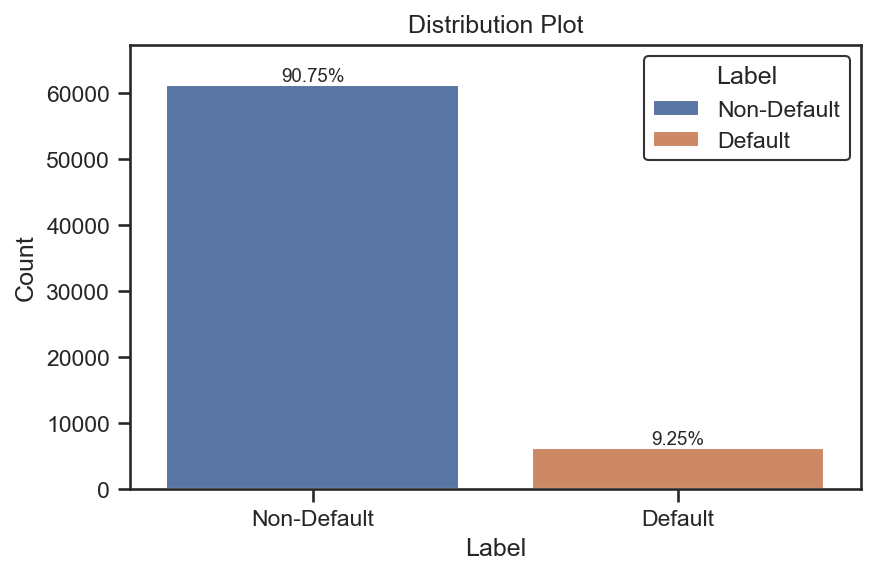

In [286]:
distribution_plot(df_train, "Loan Status", title="Distribution Plot", x_label="Label", y_label="Count")

## 4.4 Missingness

Compute column-wise missingness, a top-N missingness bar, and a lightweight heatmap (sample). Save under `results/EDA/missing/`.

In [287]:


def eda_missingness(df: pd.DataFrame, save_dir: Optional[Union[str, Path]] = None, top_n: int = 25, heatmap_sample: int = 1000) -> Dict[str, Any]:
    """
    Summarize missingness by column and save artifacts.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe to analyze.
    save_dir : Optional[Union[str, Path]], default None
        Output directory; defaults to RESULT_DIR/'EDA'/'missing'.
        Output directory for artifacts.
    top_n : int, default 25
        Plot top-N columns by missing percentage.
    heatmap_sample : int, default 1000
        Number of rows to sample for missingness heatmap (to keep plotting light).

    Returns
    -------
    dict
        Paths to saved artifacts and the missingness table.
    """
    out = Path(save_dir) if save_dir else (RESULT_DIR / 'EDA' / 'missing'); out.mkdir(parents=True, exist_ok=True)
    n=len(df)
    miss_tbl=(
        df.isna().sum().rename('missing')
        .to_frame()
        .assign(missing_pct=lambda d: (d['missing']/max(1,n))*100)
        .sort_values('missing_pct', ascending=False)
    )
    miss_tbl.to_csv(out/"missing_table.csv")

    # Bar plot top-N
    top=miss_tbl.head(top_n).reset_index().rename(columns={'index':'column'})
    plt.figure(figsize=(8, max(3, 0.25*len(top))))
    sns.barplot(data=top, x='missing_pct', y='column', color='#4C78A8')
    plt.xlabel('Missing %'); plt.ylabel('Column'); plt.title('Top Missingness')
    plt.tight_layout(); plt.savefig(out/"missing_bar.png", dpi=150); plt.close()

    # Heatmap on sample
    sample = df.sample(min(heatmap_sample, n), random_state=42) if n>0 else df
    plt.figure(figsize=(10, 6))
    sns.heatmap(sample.isna(), cbar=False)
    plt.title('Missingness Heatmap (sample)')
    plt.tight_layout(); plt.savefig(out/"missing_heatmap.png", dpi=150); plt.close()

    return {"table_path": str(out/"missing_table.csv"),
            "bar_path": str(out/"missing_bar.png"),
            "heatmap_path": str(out/"missing_heatmap.png")}


In [288]:

# Run missingness on training data
miss_artifacts = eda_missingness(df_train, save_dir=RESULT_DIR/'EDA'/'missing', top_n=25, heatmap_sample=1000)
print(miss_artifacts)


{'table_path': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/missing/missing_table.csv', 'bar_path': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/missing/missing_bar.png', 'heatmap_path': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/missing/missing_heatmap.png'}


## 4.5 Duplicates & Keys

Report duplicate rows and check ID column uniqueness. Save under `results/EDA/quality/`.

In [289]:


def eda_duplicates_and_keys(df: pd.DataFrame, id_cols=None, save_dir: Optional[Union[str, Path]] = None) -> dict:
    """
    Compute duplicate row counts and uniqueness of provided ID columns.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe to analyze.
    id_cols : list[str] or None
        Columns to validate as unique identifiers.
    save_dir : str
        Output directory.

    Returns
    -------
    dict
        Summary with paths to saved reports.
    """
    out = Path(save_dir) if save_dir else (RESULT_DIR / 'EDA' / 'quality'); out.mkdir(parents=True, exist_ok=True)
    n=len(df)
    dup_rows=int(df.duplicated().sum())
    rep=[{"metric":"duplicate_rows","value":dup_rows}]
    id_cols = id_cols or []
    for c in id_cols:
        if c in df.columns:
            non_null=int(df[c].notna().sum())
            nunique=int(df[c].nunique(dropna=True))
            rep.append({"metric":f"id_unique::{c}", "value": (nunique==non_null and non_null>0), "nunique":nunique, "non_null":non_null, "rows":n})
        else:
            rep.append({"metric":f"id_missing::{c}", "value": False})
    rpt_path=out/"duplicates_keys_report.csv"
    with rpt_path.open('w', newline='') as f:
        w=csv.DictWriter(f, fieldnames=sorted(set(k for d in rep for k in d.keys())))
        w.writeheader(); w.writerows(rep)
    return {"report_path": str(rpt_path), "duplicate_rows": dup_rows}


In [290]:

keys_artifacts = eda_duplicates_and_keys(df_train, id_cols=ID_COLS if 'ID_COLS' in globals() else [], save_dir=RESULT_DIR/'EDA'/'quality')
print(keys_artifacts)


{'report_path': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/quality/duplicates_keys_report.csv', 'duplicate_rows': 0}


## 4.6 Numerical Profiling

Compute numeric summary stats and IQR-based outlier counts. Save under `results/EDA/numeric/`.

In [291]:


def eda_numeric_profile(df: pd.DataFrame, drop_cols=None, save_dir: Optional[Union[str, Path]] = None) -> dict:
    """
    Summarize numeric columns with stats and IQR outlier counts.

    Parameters
    ----------
    df : pd.DataFrame
    drop_cols : list[str] or None
        Columns to exclude (e.g., IDs, target if numeric).
    save_dir : str
        Output directory.
    """
    out = Path(save_dir) if save_dir else (RESULT_DIR / 'EDA' / 'numeric'); out.mkdir(parents=True, exist_ok=True)
    drop_cols=set(drop_cols or [])
    num_cols=[c for c in df.select_dtypes(include=['number']).columns if c not in drop_cols]
    rows=[]
    for c in num_cols:
        s=pd.to_numeric(df[c], errors='coerce').dropna()
        if s.empty:
            rows.append({"column":c, "count":0}); continue
        q1=s.quantile(0.25); q3=s.quantile(0.75); iqr=q3-q1
        lb=q1-1.5*iqr; ub=q3+1.5*iqr
        outliers=int(((s<lb)|(s>ub)).sum())
        rows.append({
            "column":c, "count":int(s.size), "mean":float(s.mean()), "std":float(s.std()),
            "min":float(s.min()), "p25":float(q1), "median":float(s.median()), "p75":float(q3), "max":float(s.max()),
            "skew":float(s.skew()), "kurtosis":float(s.kurtosis()), "iqr":float(iqr), "outliers":outliers,
            "outlier_pct": round(100.0*outliers/max(1,len(df)),3)
        })
    tbl=pd.DataFrame(rows).sort_values('outlier_pct', ascending=False)
    path=out/"numeric_summary.csv"; tbl.to_csv(path, index=False)
    return {"summary_path": str(path), "n_numeric": len(num_cols)}


In [292]:

_drop = set(ID_COLS) if 'ID_COLS' in globals() else set()
if 'TARGET_COL' in globals() and TARGET_COL in df_train.columns and pd.api.types.is_numeric_dtype(df_train[TARGET_COL]):
    _drop.add(TARGET_COL)
num_artifacts = eda_numeric_profile(df_train, drop_cols=list(_drop), save_dir=RESULT_DIR/'EDA'/'numeric')
print(num_artifacts)


{'summary_path': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/numeric/numeric_summary.csv', 'n_numeric': 24}


## 4.7 Categorical Profiling

Compute cardinality and rare levels. Save under `results/EDA/categorical/`.

In [293]:


def eda_categorical_profile(df: pd.DataFrame, save_dir: Optional[Union[str, Path]] = None, rare_thresh: float = 0.01) -> dict:
    """
    Summarize categorical-like columns: cardinality and rare levels (< rare_thresh).

    Parameters
    ----------
    df : pd.DataFrame
    save_dir : str
        Output directory.
    rare_thresh : float
        Frequency threshold for rare-level flagging (fraction of non-null).
    """
    out = Path(save_dir) if save_dir else (RESULT_DIR / 'EDA' / 'categorical'); out.mkdir(parents=True, exist_ok=True)
    cat_cols=[c for c in df.columns if (not pd.api.types.is_numeric_dtype(df[c]))]
    rows=[]; rare_rows=[]
    for c in cat_cols:
        s=df[c].astype('string')
        nn=int(s.notna().sum()); nu=int(s.nunique(dropna=True))
        rows.append({"column":c, "non_nulls":nn, "nunique":nu})
        if nn>0:
            freq=s.dropna().value_counts(normalize=True)
            rare=freq[freq<rare_thresh]
            for v,p in rare.items():
                rare_rows.append({"column":c, "value":str(v), "freq_pct":round(100.0*float(p),3)})
    card=pd.DataFrame(rows).sort_values('nunique', ascending=False)
    card.to_csv(out/"cardinality.csv", index=False)
    rare_tbl=pd.DataFrame(rare_rows)
    if not rare_tbl.empty:
        rare_tbl.to_csv(out/"rare_levels.csv", index=False)
    return {"cardinality_path": str(out/"cardinality.csv"), "rare_levels_path": (str(out/"rare_levels.csv") if not rare_tbl.empty else None)}


In [294]:

cat_artifacts = eda_categorical_profile(df_train, save_dir=RESULT_DIR/'EDA'/'categorical', rare_thresh=0.01)
print(cat_artifacts)


{'cardinality_path': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/categorical/cardinality.csv', 'rare_levels_path': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/categorical/rare_levels.csv'}


## 4.8 Correlations & Redundancy

Spearman correlation heatmap for numeric features and high-correlation pairs report. Save under `results/EDA/corr/`.

In [295]:
def eda_correlations(df: pd.DataFrame, save_dir: Optional[Union[str, Path]] = None, threshold: float = 0.95) -> dict:
    """
    Compute Spearman correlation over numeric columns and save artifacts.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    save_dir : Optional[Union[str, Path]], default None
        Output directory; defaults to RESULT_DIR/'EDA'/'corr'.
    threshold : float, default 0.95
        Absolute correlation threshold to report high-correlation pairs.

    Returns
    -------
    dict
        Paths to correlation CSV, heatmap PNG, and high-correlation pairs CSV.
    """
    out = Path(save_dir) if save_dir else (RESULT_DIR / 'EDA' / 'corr')
    out.mkdir(parents=True, exist_ok=True)
    num = df.select_dtypes(include=['number'])
    if num.shape[1] == 0:
        return {"message": "no numeric columns"}
    corr = num.corr(method='spearman')
    corr.to_csv(out / 'spearman_corr.csv')
    plt.figure(figsize=(min(12, 0.4 * corr.shape[1] + 3), min(10, 0.4 * corr.shape[0] + 3)))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title('Spearman Correlation (numeric)')
    plt.tight_layout()
    plt.savefig(out / 'corr_heatmap.png', dpi=150)
    plt.close()
    # High-correlation pairs (upper triangle)
    pairs = []
    cols = corr.columns
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            v = corr.iloc[i, j]
            if abs(v) >= threshold:
                pairs.append({'col_a': cols[i], 'col_b': cols[j], 'rho': float(v)})
    high = pd.DataFrame(pairs, columns=['col_a', 'col_b', 'rho'])
    if not high.empty:
        high = high.sort_values('rho', key=lambda s: s.abs(), ascending=False)
    high.to_csv(out / 'high_corr_pairs.csv', index=False)
    return {
        'corr_csv': str(out / 'spearman_corr.csv'),
        'heatmap': str(out / 'corr_heatmap.png'),
        'high_pairs': str(out / 'high_corr_pairs.csv'),
    }


In [296]:

corr_artifacts = eda_correlations(df_train, save_dir=RESULT_DIR/'EDA'/'corr', threshold=0.95)
print(corr_artifacts)


{'corr_csv': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/corr/spearman_corr.csv', 'heatmap': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/corr/corr_heatmap.png', 'high_pairs': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/corr/high_corr_pairs.csv'}


## 4.9 Leakage Checks

Heuristic checks for potential leakage columns. Save under `results/EDA/leakage/`.

In [297]:


def eda_leakage_checks(train: pd.DataFrame, test: pd.DataFrame, target: str, save_dir: Optional[Union[str, Path]] = None) -> dict:
    out = Path(save_dir) if save_dir else (RESULT_DIR / 'EDA' / 'leakage'); out.mkdir(parents=True, exist_ok=True)
    suspects=[]
    # Present only in train
    only_train=[c for c in train.columns if c not in test.columns]
    for c in only_train:
        if c==target: continue
        suspects.append({"column":c, "reason":"present_only_in_train"})
    # Name-based
    tokens=["status","default","outcome","result","label"]
    for c in train.columns:
        cl=c.lower()
        if any(t in cl for t in tokens) and c!=target:
            suspects.append({"column":c, "reason":"suspicious_name"})
    # Correlation with target (if target binary)
    try:
        y=train[target]
        if y.nunique(dropna=True)==2:
            # map to 0/1
            y_map={v:i for i,v in enumerate(sorted(y.dropna().unique()))}
            y_num=y.map(y_map)
            num=train.select_dtypes(include=['number'])
            for c in num.columns:
                if c==target: continue
                s=pd.to_numeric(train[c], errors='coerce')
                r= np.corrcoef(s.fillna(s.median()), y_num.fillna(y_num.median()))[0,1]
                if np.isfinite(r) and abs(r)>=0.3:
                    suspects.append({"column":c, "reason":"high_corr_with_target", "corr": float(r)})
    except Exception:
        pass
    # Save
    rpt=out/"leakage_report.csv"
    with rpt.open('w', newline='') as f:
        fields=sorted(set(k for d in suspects for k in d.keys())) or ["column","reason"]
        w=csv.DictWriter(f, fieldnames=fields); w.writeheader();
        for d in suspects: w.writerow(d)
    # Markdown summary
    md = out/'leakage_report.md'
    with md.open('w') as f:
        f.write('# Leakage Report\n\n')
        f.write(f"- Present only in train: {sum(1 for s in suspects if s.get('reason')=='present_only_in_train')}\n")
        f.write(f"- Suspicious names: {sum(1 for s in suspects if s.get('reason')=='suspicious_name')}\n")
        f.write(f"- High corr with target: {sum(1 for s in suspects if s.get('reason')=='high_corr_with_target')}\n")
    return {'report_csv': str(rpt), 'report_md': str(md)}


In [298]:

leak_artifacts = eda_leakage_checks(df_train, df_test, target=TARGET_COL, save_dir=RESULT_DIR/'EDA'/'leakage')
print(leak_artifacts)


{'report_csv': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/leakage/leakage_report.csv', 'report_md': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/leakage/leakage_report.md'}


/Users/enigma/anaconda3/envs/DS/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/enigma/anaconda3/envs/DS/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## 4.10 Train–Test Alignment

Compare schema and numeric ranges; detect unseen categories. Save under `results/EDA/alignment/`.

In [299]:


def eda_alignment(train: pd.DataFrame, test: pd.DataFrame, save_dir: Optional[Union[str, Path]] = None) -> dict:
    out = Path(save_dir) if save_dir else (RESULT_DIR / 'EDA' / 'alignment'); out.mkdir(parents=True, exist_ok=True)
    # Schema
    schema=[]
    common= [c for c in train.columns if c in test.columns]
    for c in common:
        schema.append({"column":c, "train_dtype": str(train[c].dtype), "test_dtype": str(test[c].dtype), "dtype_match": str(train[c].dtype)==str(test[c].dtype)})
    pd.DataFrame(schema).to_csv(out/"schema_check.csv", index=False)
    # Range check for numeric
    rows=[]
    for c in common:
        if pd.api.types.is_numeric_dtype(train[c]) and pd.api.types.is_numeric_dtype(test[c]):
            tr=pd.to_numeric(train[c], errors='coerce')
            te=pd.to_numeric(test[c], errors='coerce')
            tr_min,tr_max= tr.min(), tr.max()
            outside=int(((te<tr_min)|(te>tr_max)).sum())
            rows.append({"column":c, "train_min":float(tr_min) if pd.notna(tr_min) else None,
                         "train_max":float(tr_max) if pd.notna(tr_max) else None,
                         "test_outside_count": outside,
                         "test_outside_pct": round(100.0*outside/max(1,len(test)),3)})
    pd.DataFrame(rows).to_csv(out/"range_check.csv", index=False)
    # Unseen categories
    cat_rows=[]
    for c in common:
        if not pd.api.types.is_numeric_dtype(train[c]):
            tr=set(train[c].dropna().astype('string').unique())
            te=set(test[c].dropna().astype('string').unique())
            unseen= te - tr
            cat_rows.append({"column":c, "unseen_in_test": len(unseen)})
    pd.DataFrame(cat_rows).to_csv(out/"unseen_categories.csv", index=False)
    return {"schema": str(out/"schema_check.csv"), "range": str(out/"range_check.csv"), "unseen": str(out/"unseen_categories.csv")}


In [300]:

align_artifacts = eda_alignment(df_train, df_test, save_dir=RESULT_DIR/'EDA'/'alignment')
print(align_artifacts)


{'schema': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/alignment/schema_check.csv', 'range': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/alignment/range_check.csv', 'unseen': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/alignment/unseen_categories.csv'}


## 4.11 Interactions & Bivariate

Compute mutual information with the target and save top features; generate a few example plots. Save under `results/EDA/bivariate/`.

In [301]:


def eda_bivariate(train: pd.DataFrame, target: str, save_dir: Optional[Union[str, Path]] = None, top_k: int = 15) -> dict:
    out = Path(save_dir) if save_dir else (RESULT_DIR / 'EDA' / 'bivariate'); out.mkdir(parents=True, exist_ok=True)
    y=train[target]
    # Encode target to numeric 0/1 if binary
    if y.nunique(dropna=True)==2:
        classes= list(y.dropna().unique())
        y_enc=y.map({classes[0]:0, classes[1]:1})
    else:
        # Fallback: factorize multi-class
        y_enc=pd.factorize(y, sort=True)[0]
    # Feature matrix: numeric + encoded categoricals
    X_parts=[]; col_names=[]
    for c in train.columns:
        if c==target: continue
        s=train[c]
        if pd.api.types.is_numeric_dtype(s):
            X_parts.append(pd.to_numeric(s, errors='coerce').fillna(s.median()))
            col_names.append(c)
        else:
            # limited cardinality one-hot (top levels)
            d=pd.get_dummies(s.astype('string'), dummy_na=False)
            # guard against huge expansions
            if d.shape[1]>50:
                d=d.iloc[:, :50]
            X_parts.append(d)
            col_names.extend([f"{c}__{k}" for k in d.columns])
    if not X_parts:
        return {"message":"no features"}
    X=pd.concat(X_parts, axis=1).fillna(0)
    mi = mutual_info_classif(X, y_enc, discrete_features=[not pd.api.types.is_numeric_dtype(X[c]) for c in X.columns])
    mi_tbl=pd.DataFrame({"feature": X.columns, "mi": mi}).sort_values('mi', ascending=False)
    mi_tbl.to_csv(out/"mutual_information.csv", index=False)
    # Simple example plots for top 3 numeric / top 3 categorical (if present)
    top_feats=mi_tbl.head(top_k)['feature'].tolist()
    # save list
    with open(out/"top_features.txt", 'w') as f:
        for t in top_feats: f.write(str(t)+ '\\n')
    return {"mi_csv": str(out/"mutual_information.csv"), "top_features": str(out/"top_features.txt")}


In [302]:

biv_artifacts = eda_bivariate(df_train, target=TARGET_COL, save_dir=RESULT_DIR/'EDA'/'bivariate', top_k=15)
print(biv_artifacts)


{'mi_csv': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/bivariate/mutual_information.csv', 'top_features': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/bivariate/top_features.txt'}


## 4.12 Data Quality Flags

Flag constant, near-constant, and mixed-type columns. Save under `results/EDA/quality/`.

In [303]:


def eda_quality_flags(df: pd.DataFrame, save_dir: Optional[Union[str, Path]] = None, near_const_thresh: float = 0.99) -> dict:
    out = Path(save_dir) if save_dir else (RESULT_DIR / 'EDA' / 'quality'); out.mkdir(parents=True, exist_ok=True)
    n=len(df)
    rows=[]
    for c in df.columns:
        s=df[c]
        nunq=int(s.nunique(dropna=True)); non_null=int(s.notna().sum())
        mixed=False
        if s.dtype==object:
            try:
                sample = s.dropna().sample(min(1000, non_null), random_state=42)
            except ValueError:
                sample = s.dropna()
            types = {type(x) for x in sample}
            mixed = len(types)>1
        const = nunq<=1
        # near-constant: dominant level fraction among non-null
        if non_null>0:
            dom_frac = float(s.value_counts(dropna=False).iloc[0]/ max(1, len(s)))
        else:
            dom_frac=0.0
        near_const = (dom_frac>=near_const_thresh) and not const
        rows.append({"column":c, "non_nulls":non_null, "nunique":nunq, "constant":const, "near_constant":near_const, "mixed_types":mixed})
    tbl=pd.DataFrame(rows).sort_values(['constant','near_constant','mixed_types'], ascending=False)
    path=out/"data_quality_flags.csv"; tbl.to_csv(path, index=False)
    return {"flags_path": str(path)}


In [304]:

quality_artifacts = eda_quality_flags(df_train, save_dir=RESULT_DIR/'EDA'/'quality', near_const_thresh=0.99)
print(quality_artifacts)


{'flags_path': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/quality/data_quality_flags.csv'}


## 4.13 Consolidated Summary

Write a concise EDA summary and ETL plan placeholders under `results/EDA/summary/`.

In [305]:
def eda_consolidated_summary(context_path: Optional[Union[str, Path]] = None, save_dir: Optional[Union[str, Path]] = None) -> dict:
    """
    Write a concise EDA summary and ETL plan placeholders.

    Parameters
    ----------
    context_path : Optional[Union[str, Path]], default None
        Path to context JSON; defaults to RESULT_DIR/'EDA'/'context'/'config.json'.
    save_dir : Optional[Union[str, Path]], default None
        Output directory; defaults to RESULT_DIR/'EDA'/'summary'.
    """
    out = Path(save_dir) if save_dir else (RESULT_DIR / 'EDA' / 'summary')
    out.mkdir(parents=True, exist_ok=True)
    ctx_path = Path(context_path) if context_path else (RESULT_DIR / 'EDA' / 'context' / 'config.json')
    ctx = {}
    if ctx_path.exists():
        import json as _json
        ctx = _json.loads(ctx_path.read_text())
    # Build summary text
    summary = f"""# EDA Summary

- Target: {ctx.get('target_col')} | Positive: {ctx.get('positive_label')}

Artifacts are available under {RESULT_DIR/'EDA'}/.

Next: implement ETL based on missingness/categorical/numeric analyses.
"""
    (out / 'summary.md').write_text(summary)
    etl_plan = """# ETL Plan (Draft)

- Imputation: median for numeric; mode or explicit NA level for categorical.
- Encoding: one-hot for categoricals (with rare-level binning).
- Scaling: as required by model family.
- Feature pruning: drop constant/near-constant and highly correlated numeric pairs.
"""
    (out / 'etl_plan.md').write_text(etl_plan)
    return {'summary_md': str(out / 'summary.md'), 'etl_plan_md': str(out / 'etl_plan.md')}


In [306]:

sum_artifacts = eda_consolidated_summary(context_path=RESULT_DIR/'EDA'/'context'/'config.json', save_dir=RESULT_DIR/'EDA'/'summary')
print(sum_artifacts)


{'summary_md': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/summary/summary.md', 'etl_plan_md': '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/summary/etl_plan.md'}


## 4.6a Numeric Top-K by Target

Plot overlaid distributions for the top-K numeric features by mutual information with the target. Outputs saved to `RESULT_DIR/'EDA'/'numeric'/'dists'`.

In [307]:

from typing import Optional, Union, List, Tuple

def eda_plot_numeric_topk(
    train: pd.DataFrame,
    target: str,
    pos_label: Optional[object] = None,
    k: int = 3,
    drop_cols: Optional[List[str]] = None,
    save_dir: Optional[Union[str, Path]] = None,
) -> List[str]:
    """
    Select top-K numeric features by mutual information with the target and plot class-overlaid histograms.

    Parameters
    ----------
    train : DataFrame
    target : str
        Target column name.
    pos_label : object, optional
        Positive class label; if None, uses minority class.
    k : int, default 3
        Number of features to plot.
    drop_cols : list[str], optional
        Columns to exclude (IDs, target, etc.).
    save_dir : Optional[str|Path], default None
        Output directory; defaults to RESULT_DIR/'EDA'/'numeric'/'dists'.

    Returns
    -------
    list[str]
        Paths of saved figures.
    """
    out = Path(save_dir) if save_dir else (RESULT_DIR / 'EDA' / 'numeric' / 'dists')
    out.mkdir(parents=True, exist_ok=True)
    df = train.copy()
    y = df[target]
    # Encode y -> 0/1
    if pos_label is None:
        vc = y.value_counts(dropna=False)
        pos_label = vc.index[-1] if not vc.empty else None
    y_enc = (y == pos_label).astype(int)
    # Candidate numeric columns
    drop = set(drop_cols or []) | {target}
    num_cols = [c for c in df.select_dtypes(include=['number']).columns if c not in drop]
    if not num_cols:
        return []
    X = df[num_cols].apply(pd.to_numeric, errors='coerce')
    X = X.fillna(X.median())
    mi = mutual_info_classif(X, y_enc, discrete_features=False, random_state=42)
    order = pd.Series(mi, index=num_cols).sort_values(ascending=False).head(k).index.tolist()
    saved = []
    for col in order:
        x0 = X.loc[y_enc==0, col].values
        x1 = X.loc[y_enc==1, col].values
        plt.figure(figsize=(7,4.5))
        bins = 40
        plt.hist(x0, bins=bins, density=True, alpha=0.5, label='Non-default', color='#4C78A8', edgecolor='white')
        plt.hist(x1, bins=bins, density=True, alpha=0.5, label='Default', color='#F58518', edgecolor='white')
        plt.title(f'Distribution of {col} by {target}')
        plt.xlabel(col); plt.ylabel('Density'); plt.legend(frameon=True)
        path = out / f"{col}_by_{target}.png"
        plt.tight_layout(); plt.savefig(path, dpi=150); plt.close()
        saved.append(str(path))
    return saved


In [308]:

_drop = list(ID_COLS) if 'ID_COLS' in globals() else []
num_plot_paths = eda_plot_numeric_topk(df_train, target=TARGET_COL, pos_label=POS_LABEL, k=3, drop_cols=_drop, save_dir=RESULT_DIR/'EDA'/'numeric'/'dists')
print(num_plot_paths)


['/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/numeric/dists/Term_by_Loan Status.png', '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/numeric/dists/Collection Recovery Fee_by_Loan Status.png', '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/numeric/dists/Loan Amount_by_Loan Status.png']


## 4.7a Categorical Top-K Default Rate

Plot default rate per level for the top-K categorical features by mutual information. Outputs saved to `RESULT_DIR/'EDA'/'categorical'`.

In [309]:

from typing import Optional, Union, List

def eda_plot_categorical_topk(
    train: pd.DataFrame,
    target: str,
    pos_label: Optional[object] = None,
    k: int = 3,
    top_n_levels: int = 12,
    drop_cols: Optional[List[str]] = None,
    save_dir: Optional[Union[str, Path]] = None,
) -> List[str]:
    """
    Select top-K categorical features by mutual information and plot default rate per level (sorted). 

    Parameters
    ----------
    train : DataFrame
    target : str
    pos_label : object, optional
    k : int, default 3
    top_n_levels : int, default 12
        Maximum number of levels shown; tail grouped as 'Other'.
    drop_cols : list[str], optional
        Columns to exclude.
    save_dir : Optional[str|Path], default None
        Output directory; defaults to RESULT_DIR/'EDA'/'categorical'.

    Returns
    -------
    list[str]
        Paths to saved figures.
    """
    out = Path(save_dir) if save_dir else (RESULT_DIR / 'EDA' / 'categorical')
    out.mkdir(parents=True, exist_ok=True)
    df = train.copy()
    y = df[target]
    if pos_label is None:
        vc = y.value_counts(dropna=False)
        pos_label = vc.index[-1] if not vc.empty else None
    y_enc = (y == pos_label).astype(int)
    drop = set(drop_cols or []) | {target}
    cat_cols = [c for c in df.columns if (c not in drop) and (not pd.api.types.is_numeric_dtype(df[c]))]
    if not cat_cols:
        return []
    # Compute MI on per-column encoded codes
    scores = []
    for c in cat_cols:
        s = df[c].astype('string').fillna('<NA>')
        codes, _ = pd.factorize(s, sort=False)
        X = pd.DataFrame({c: codes})
        try:
            mi = mutual_info_classif(X, y_enc, discrete_features=True, random_state=42)
            scores.append((c, float(mi[0])))
        except Exception:
            continue
    if not scores:
        return []
    order = [c for c,_ in sorted(scores, key=lambda t: t[1], reverse=True)[:k]]
    saved = []
    for c in order:
        s = df[c].astype('string')
        tmp = pd.DataFrame({c: s, 'y': y_enc})
        # limit levels by frequency
        top_levels = tmp[c].value_counts().index.tolist()[:top_n_levels]
        tmp[c] = tmp[c].where(tmp[c].isin(top_levels), 'Other')
        grp = tmp.groupby(c)['y'].agg(['mean','count']).rename(columns={'mean':'default_rate'})
        grp = grp.sort_values('default_rate', ascending=False)
        plt.figure(figsize=(8, max(3, 0.3*len(grp))))
        plt.bar(grp.index, grp['default_rate'], color='#4C78A8')
        plt.xticks(rotation=45, ha='right')
        for i,(lvl,row) in enumerate(grp.iterrows()):
            plt.text(i, row['default_rate']+0.005, f"{row['default_rate']*100:.1f}%", ha='center', va='bottom', fontsize=9)
        plt.ylim(0, min(1.0, grp['default_rate'].max()*1.15+0.05))
        plt.ylabel('Default Rate'); plt.xlabel(c)
        plt.title(f'Default Rate by {c}')
        path = out / f"{c}_by_{target}.png"
        plt.tight_layout(); plt.savefig(path, dpi=150); plt.close()
        saved.append(str(path))
    return saved


In [310]:

_drop = list(ID_COLS) if 'ID_COLS' in globals() else []
cat_plot_paths = eda_plot_categorical_topk(df_train, target=TARGET_COL, pos_label=POS_LABEL, k=3, top_n_levels=12, drop_cols=_drop, save_dir=RESULT_DIR/'EDA'/'categorical')
print(cat_plot_paths)


['/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/categorical/Loan Title_by_Loan Status.png', '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/categorical/Batch Enrolled_by_Loan Status.png', '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/categorical/Sub Grade_by_Loan Status.png']


## 4.11a Decile Default Rate (Top 2 Numeric)

Plot default rate across deciles for the two strongest numeric features. Outputs saved to `RESULT_DIR/'EDA'/'bivariate'`.

In [311]:

from typing import List

def eda_plot_decile_rate_top2(
    train: pd.DataFrame,
    target: str,
    pos_label: Optional[object] = None,
    top2_cols: Optional[List[str]] = None,
    save_dir: Optional[Union[str, Path]] = None,
) -> List[str]:
    """
    Plot default rate vs decile for two numeric features (either provided or selected by MI).
    """
    out = Path(save_dir) if save_dir else (RESULT_DIR / 'EDA' / 'bivariate')
    out.mkdir(parents=True, exist_ok=True)
    df = train.copy()
    y = df[target]
    if pos_label is None:
        vc = y.value_counts(dropna=False)
        pos_label = vc.index[-1] if not vc.empty else None
    y_enc = (y == pos_label).astype(int)
    if not top2_cols:
        num_cols = df.select_dtypes(include=['number']).columns.tolist()
        if target in num_cols:
            num_cols.remove(target)
        X = df[num_cols].apply(pd.to_numeric, errors='coerce').fillna(df[num_cols].median())
        mi = mutual_info_classif(X, y_enc, discrete_features=False, random_state=42)
        top2_cols = pd.Series(mi, index=num_cols).sort_values(ascending=False).head(2).index.tolist()
    saved=[]
    for c in top2_cols:
        x = pd.to_numeric(df[c], errors='coerce')
        try:
            bins = pd.qcut(x, q=10, duplicates='drop')
        except ValueError:
            # constant column
            continue
        tmp = pd.DataFrame({'bin': bins, 'y': y_enc})
        rate = tmp.groupby('bin')['y'].mean()
        plt.figure(figsize=(7,4))
        plt.plot(range(1, len(rate)+1), rate.values, marker='o', color='#4C78A8')
        plt.xticks(range(1, len(rate)+1))
        plt.xlabel(f'{c} deciles'); plt.ylabel('Default Rate'); plt.title(f'Default Rate by {c} decile')
        for i,v in enumerate(rate.values, start=1):
            plt.text(i, v+0.005, f"{v*100:.1f}%", ha='center', va='bottom', fontsize=9)
        plt.ylim(0, min(1.0, rate.max()*1.15+0.05))
        path = out / f"{c}_deciles_rate.png"
        plt.tight_layout(); plt.savefig(path, dpi=150); plt.close()
        saved.append(str(path))
    return saved


In [312]:

decile_paths = eda_plot_decile_rate_top2(df_train, target=TARGET_COL, pos_label=POS_LABEL, top2_cols=None, save_dir=RESULT_DIR/'EDA'/'bivariate')
print(decile_paths)


['/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/bivariate/Term_deciles_rate.png', '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/bivariate/Collection Recovery Fee_deciles_rate.png']


/var/folders/32/g_5ff_b9667068lbxcnk8vzr0000gn/T/ipykernel_88107/1945562380.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = tmp.groupby('bin')['y'].mean()
/var/folders/32/g_5ff_b9667068lbxcnk8vzr0000gn/T/ipykernel_88107/1945562380.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = tmp.groupby('bin')['y'].mean()


## 4.10a Train–Test Drift Overlays

Overlay train vs test for top drifted features (numeric ×2, categorical ×1). Outputs saved to `RESULT_DIR/'EDA'/'alignment'`.

In [313]:

from typing import Tuple

def eda_plot_train_test_drift(
    train: pd.DataFrame,
    test: pd.DataFrame,
    save_dir: Optional[Union[str, Path]] = None,
    numeric_topn: int = 2,
    categorical_topn: int = 1,
) -> Tuple[List[str], List[str]]:
    """
    Plot train vs test overlays for numeric (hist density) and categorical (side-by-side bars) features.
    Select features by simple drift scores: |mean_train - mean_test| / (std_train + 1e-9) for numeric,
    and L1 distance between normalized level frequencies for categorical.
    """
    out = Path(save_dir) if save_dir else (RESULT_DIR / 'EDA' / 'alignment')
    out.mkdir(parents=True, exist_ok=True)
    num_cols = train.select_dtypes(include=['number']).columns
    num_scores = []
    for c in num_cols:
        tr = pd.to_numeric(train[c], errors='coerce'); te = pd.to_numeric(test[c], errors='coerce')
        mu_t, mu_s = tr.mean(), te.mean(); sd_t = tr.std() or 1e-9
        score = abs(mu_t - mu_s) / (abs(sd_t) + 1e-9)
        num_scores.append((c, float(score)))
    top_num = [c for c,_ in sorted(num_scores, key=lambda t: t[1], reverse=True)[:numeric_topn]]
    num_paths=[]
    for c in top_num:
        tr = pd.to_numeric(train[c], errors='coerce').dropna(); te = pd.to_numeric(test[c], errors='coerce').dropna()
        plt.figure(figsize=(7,4))
        bins = 40
        plt.hist(tr, bins=bins, density=True, alpha=0.5, label='Train', color='#4C78A8', edgecolor='white')
        plt.hist(te, bins=bins, density=True, alpha=0.5, label='Test', color='#F58518', edgecolor='white')
        plt.title(f'Train vs Test — {c}')
        plt.xlabel(c); plt.ylabel('Density'); plt.legend(frameon=True)
        path = out / f"{c}_train_vs_test.png"; plt.tight_layout(); plt.savefig(path, dpi=150); plt.close()
        num_paths.append(str(path))
    # Categorical drift
    cat_cols = [c for c in train.columns if not pd.api.types.is_numeric_dtype(train[c])]
    cat_scores=[]
    for c in cat_cols:
        tr = train[c].astype('string'); te = test[c].astype('string')
        f_tr = (tr.value_counts(normalize=True)); f_te = (te.value_counts(normalize=True))
        # align indices
        idx = f_tr.index.union(f_te.index)
        f_tr = f_tr.reindex(idx, fill_value=0.0); f_te = f_te.reindex(idx, fill_value=0.0)
        score = float((f_tr - f_te).abs().sum())
        cat_scores.append((c, score))
    top_cat = [c for c,_ in sorted(cat_scores, key=lambda t: t[1], reverse=True)[:categorical_topn]] if cat_scores else []
    cat_paths=[]
    for c in top_cat:
        tr = train[c].astype('string'); te = test[c].astype('string')
        f_tr = (tr.value_counts(normalize=True)); f_te = (te.value_counts(normalize=True))
        idx = f_tr.index.union(f_te.index)
        f_tr = f_tr.reindex(idx, fill_value=0.0); f_te = f_te.reindex(idx, fill_value=0.0)
        x = np.arange(len(idx)); width=0.45
        plt.figure(figsize=(max(7, 0.25*len(idx)+2),4))
        plt.bar(x - width/2, f_tr.values, width=width, label='Train', color='#4C78A8')
        plt.bar(x + width/2, f_te.values, width=width, label='Test', color='#F58518')
        plt.xticks(x, idx, rotation=45, ha='right')
        plt.ylabel('Proportion'); plt.xlabel(c); plt.title(f'Train vs Test — {c}')
        plt.legend(frameon=True)
        path = out / f"{c}_train_vs_test.png"; plt.tight_layout(); plt.savefig(path, dpi=150); plt.close()
        cat_paths.append(str(path))
    return num_paths, cat_paths


In [314]:

num_paths, cat_paths = eda_plot_train_test_drift(df_train, df_test, save_dir=RESULT_DIR/'EDA'/'alignment', numeric_topn=2, categorical_topn=1)
print(num_paths, cat_paths)


['/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/alignment/Accounts Delinquent_train_vs_test.png', '/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/alignment/Term_train_vs_test.png'] ['/Volumes/DataBank1/00-DataBank/GitHub/DataScience/Project4-BankLoanDefaultPrediction/results/EDA/alignment/Loan Title_train_vs_test.png']
